In [34]:
import json
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from openai import OpenAI
from bertopic.representation import OpenAI as OpenAIRep
from collections import Counter
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import numpy as np

from llmcoder.utils import get_openai_key, get_system_prompt
from llmcoder import LLMCoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
client = OpenAI(api_key=get_openai_key())

In [3]:
code = """# General imports
import os

import pandas as pd
import numpy as np
import spacy
import matplotlib
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Custom imports
from tqdm import tqdm
from collections import Counter

# Ensure matplotlib works correctly with Jupyter
%matplotlib inline

df_characters = pd.read_csv('data/simpsons_characters.csv').reset_index(inplace=False, drop=True)
df_locations = pd.read_csv('data/simpsons_locations.csv').reset_index(inplace=False, drop=True)
df_script = pd.read_csv('data/simpsons_script_lines.csv').reset_index(inplace=False, drop=True)
df_episodes = pd.read_csv('data/simpsons_episodes.csv').reset_index(inplace=False, drop=True)

# """

In [4]:
messages = [{
    "role": "system",
    "content": get_system_prompt(),
}, {
    "role": "user",
    "content": code
}]

In [5]:
N_SAMPLES = 10_000

In [7]:
assert N_SAMPLES <= 10000  # Otherwise this will get very expensive

chat_completions = []

pbar = tqdm(total=N_SAMPLES)
while len(chat_completions) < N_SAMPLES:
    chat_completion = client.chat.completions.create(messages=messages, model='ft:gpt-3.5-turbo-1106:personal::8LCi9Q0d', n=min(128, N_SAMPLES - len(chat_completions)))
    chat_completions.extend(chat_completion.choices)
    pbar.update(len(chat_completion.choices))

100%|██████████| 10000/10000 [04:59<00:00, 32.01it/s]

100%|██████████| 10000/10000 [05:10<00:00, 32.01it/s]

In [10]:
answer_list = [choice.message.content for choice in chat_completions]

len(answer_list)

10000

In [11]:
# Store the completions
with open('multi-choice-completions.json', 'w') as f:
    json.dump(answer_list, f, ensure_ascii=False, indent=4)

In [13]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(answer_list, show_progress_bar=False)

In [14]:
representation_model = OpenAI(client, model="gpt-3.5-turbo", delay_in_seconds=5, chat=True)

In [15]:
# Train BERTopic
topic_model = BERTopic(verbose=True, representation_model=representation_model).fit(answer_list, embeddings)

2023-12-08 09:26:52,073 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-08 09:27:11,133 - BERTopic - Dimensionality - Completed ✓
2023-12-08 09:27:11,134 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-08 09:27:11,271 - BERTopic - Cluster - Completed ✓
2023-12-08 09:27:11,275 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 269/269 [27:02<00:00,  6.03s/it]
2023-12-08 09:54:13,810 - BERTopic - Representation - Completed ✓


In [60]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=1, metric='cosine').fit_transform(embeddings)

In [61]:
topic_representations = [topic_model.get_topic(topic_id) for topic_id in range(len(topic_model.get_topic_freq()))]

In [62]:
topic_model.set_topic_labels(topic_representations)

In [63]:
topic_model.visualize_documents(answer_list, reduced_embeddings=reduced_embeddings, width=1800, height=1000, hide_annotations=True, title="Next Thing After Importing Data:")

In [6]:
# Store the completions
with open('multi-choice-completions.json', 'r') as f:
    answer_list = json.load(f)

len(answer_list)

10000

In [12]:
from transformers import AutoTokenizer
from transformers import RobertaConfig, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
model = RobertaForSequenceClassification.from_pretrained('../code_bert/score_codebert_16').to(device)

In [20]:
scores = []

for answer in tqdm(answer_list):
    full_code = code + answer

    # If the full_code is longer than 512 tokens, we need to truncate it
    while len(tokenizer.encode(full_code, return_tensors="pt")[0]) > 512:
        full_code = full_code[1:]

    input_ids = tokenizer.encode(full_code, return_tensors="pt").to(device)
    output = model(input_ids)
    scores.append(output.logits.to("cpu").tolist())

input_ids = tokenizer.encode(code, return_tensors="pt").to(device)
output = model(input_ids)
score_before = output.logits.to("cpu").tolist()

100%|██████████| 10000/10000 [01:07<00:00, 149.02it/s]


In [25]:
scores = np.array(scores)[:, 0, :]

In [14]:
# scoring_prompt = get_system_prompt("2023-12-09_Scorer_v1.txt")
# print(scoring_prompt)

In [15]:
# LLMCoder().score_code(code + answer_list[1496], client=client, scoring_prompt=scoring_prompt)

In [16]:
# quality_scores = []

# for answer in tqdm(answer_list):
#     full_code = code + answer
#     quality_scores.append(LLMCoder().score_code(full_code, client=client, scoring_prompt=scoring_prompt))

In [12]:
# quality_score_before = LLMCoder().score_code(code, client=client, scoring_prompt=scoring_prompt)

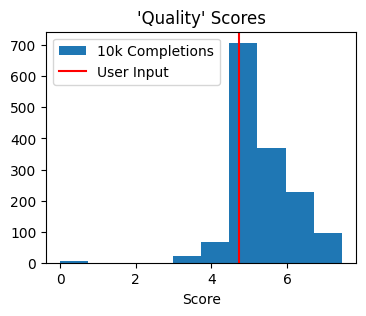

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# ax.hist(quality_scores, bins=10, label="10k Completions")
# ax.set_title("'Quality' Scores")
# ax.set_xlabel("Score")
# ax.axvline(quality_score_before, color="red", label="User Input")
# ax.legend()

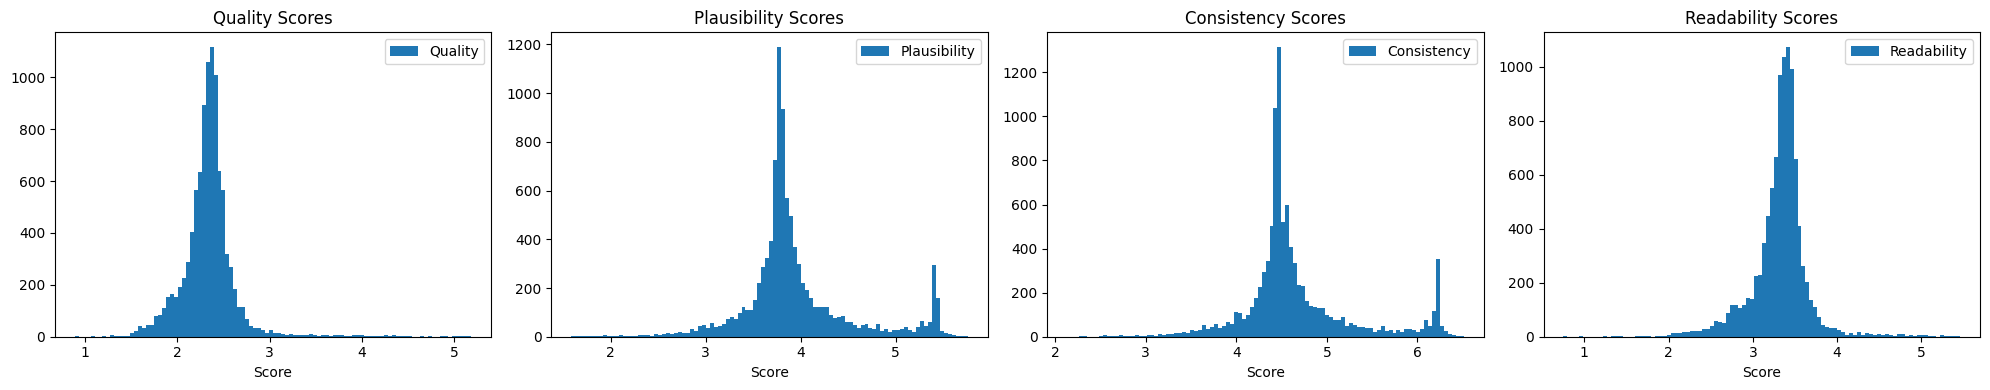

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

labels = ['Quality', 'Plausibility', 'Consistency', 'Readability']

for i, ax in enumerate(axes.flatten()):
    ax.hist(scores[:, i], bins=100, label=labels[i])
    ax.set_title(f"{labels[i]} Scores")
    ax.set_xlabel("Score")
    # ax.axvline(scores[i], color="red", label="User Input")
    ax.legend()

plt.tight_layout()

In [28]:
# Compute the geometric mean of the scores in the 4 dimensions
scores_geo = np.exp(np.mean(np.log(scores), axis=1))

Text(0.5, 0, 'Score')

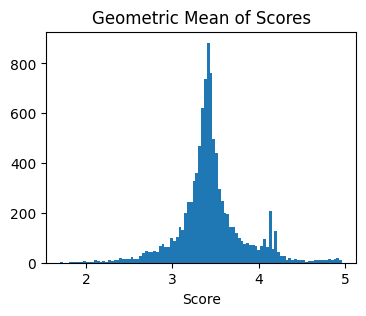

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(scores_geo, bins=100, label="10k Completions")
ax.set_title("Geometric Mean of Scores")
ax.set_xlabel("Score")

In [35]:
import numpy as np

In [36]:
# Determine the average score when sampling only once
one_choice_score_mean = np.mean(scores_geo)

# Determine the average score when sampling s choices (for s from 1 to 100)
n_repeat = 10_000
s_choices_scores = [[np.mean(np.random.choice(scores_geo, size=s).max()) for s in range(1, 101)] for _ in tqdm(range(n_repeat))]

100%|██████████| 10000/10000 [00:12<00:00, 795.28it/s]


In [37]:
s_choices_scores_mean = np.mean(s_choices_scores, axis=0)
s_choices_scores_std = np.std(s_choices_scores, axis=0)

In [38]:
# Determine at which s the mean expected score for s choices is as good as the mean score of sampling only once plus the standard deviation of sampling only once
# Repeat this for 1, 2, and 3 standard deviations
sigma_improvements = []
for std in [1, 2, 3]:
    s_choices_scores_mean_plus_std = one_choice_score_mean + std * np.std(scores_geo)
    s_choices_scores_mean_plus_std_idx = np.where(s_choices_scores_mean > s_choices_scores_mean_plus_std)[0][0]
    print(f"Sampling {s_choices_scores_mean_plus_std_idx} choices is as good as sampling only once plus {std} standard deviations")
    sigma_improvements.append((std, s_choices_scores_mean_plus_std_idx, s_choices_scores_mean_plus_std))

Sampling 3 choices is as good as sampling only once plus 1 standard deviations
Sampling 15 choices is as good as sampling only once plus 2 standard deviations
Sampling 67 choices is as good as sampling only once plus 3 standard deviations


In [39]:
sigma_improvements

[(1, 3, 3.8319795687282205),
 (2, 15, 4.217467270170677),
 (3, 67, 4.6029549716131335)]

In [40]:
# Also compute the pareto frontier, i.e. the s for which the mean expected score for s choices exceeds the 80th percentile of the score distribution
s_choices_scores_mean_80th_percentile = np.percentile(scores_geo, 80)
s_choices_scores_mean_80th_percentile_idx = np.where(s_choices_scores_mean > s_choices_scores_mean_80th_percentile)[0][0]

print(f"Sampling {s_choices_scores_mean_80th_percentile_idx} choices is as good as sampling only once plus the 80th percentile of the score distribution")

Sampling 2 choices is as good as sampling only once plus the 80th percentile of the score distribution


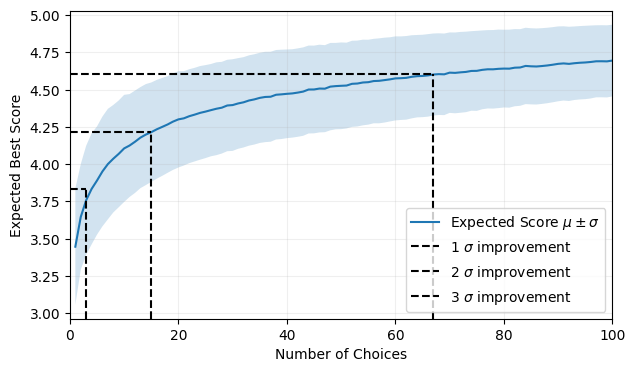

In [41]:
# Plot the scores as a function of s
fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.plot(range(1, 101), s_choices_scores_mean, label="Expected Score $\mu \pm \sigma$")
ax.fill_between(range(1, 101), s_choices_scores_mean - s_choices_scores_std, s_choices_scores_mean + s_choices_scores_std, alpha=0.2)
# ax.axhline(one_choice_score_mean, color="red", label="One Choice $\mu \pm \sigma$")
# ax.fill_between(range(1, 101), one_choice_score_mean - np.std(quality_scores), one_choice_score_mean + np.std(quality_scores), alpha=0.1, color="red")
ax.set_xlabel("Number of Choices")
ax.set_ylabel("Expected Best Score")

ylim = ax.get_ylim()

for sigma, s_choices_scores_mean_plus_std_idx, s_choices_scores_mean_plus_std in sigma_improvements:
    ax.plot([s_choices_scores_mean_plus_std_idx, s_choices_scores_mean_plus_std_idx], [ylim[0], s_choices_scores_mean_plus_std], color="black", linestyle="--", label=f"{sigma} $\sigma$ improvement")
    ax.plot([0, s_choices_scores_mean_plus_std_idx], [s_choices_scores_mean_plus_std, s_choices_scores_mean_plus_std], color="black", linestyle="--")

ax.set_ylim(ylim)
ax.set_xlim(0, 100)
ax.legend(loc="lower right")
ax.grid(alpha=0.2);

In [57]:
# Show the best quality answers
best_quality_answers = sorted(zip(scores[:, 1], answer_list, range(len(answer_list))), reverse=True)
for quality, answer, score_id in best_quality_answers[:10]:
    print(f"Quality: {quality:.5f}, Scores: {scores[score_id]}\nAnswer: {answer}\n")

Quality: 5.75583, Scores: [1.93765008 5.75583315 6.51263523 2.81781983]
Answer: Merge the characters and locations dataframes with the script dataframe
df_script = df_script.merge(df_characters, left_on='character_id', right_on='id')
df_script = df_script.merge(df_locations, left_on='location_id', right_on='id')

# Reorder columns
df_script = df_script[['id_x', 'episode_id', 'number', 'raw_text', 'timestamp_in_ms', 'speaking_line', 
                       'character_id', 'name_x', 'normalized_text_y', 'location_id', 'name_y', 'image_url', 
                       'normalized_text_x', 'wikipedia_url', 'number_y', 'normalized_text']]

Quality: 5.73750, Scores: [1.86972809 5.73750162 6.50012112 2.74454451]
Answer: Merge relevant data
df_merged = pd.merge(df_script, df_episodes,
                     on='episode_id',
                     how='left')

df_merged = pd.merge(df_merged, df_characters,
                     on='character_id',
                     how='left')

df_merged = pd.merge(d

In [58]:
# Show the worst quality answers
worst_quality_answers = sorted(zip(scores[:, 1], answer_list, range(len(answer_list))), reverse=False)
for quality, answer, score_id in worst_quality_answers[:10]:
    print(f"Quality: {quality:.5f}, Scores: {scores[score_id]}\nAnswer: {answer}\n")

Quality: 1.58376, Scores: [1.58186424 1.58376479 2.13475108 2.06007981]
Answer:  Display a preview of each Data Frame
print('Characters Data Frame:')
print(df_characters.head())
print('\nLocations Data Frame:')
print(df_locations.head())
print('\nScript Data Frame:')
print(df_script.head())
print('\nEpisodes Data Frame:')
print(df_episodes.head())

Quality: 1.64593, Scores: [1.58056009 1.64593136 2.20339322 2.07660174]
Answer: # Ensure correct versions
print(f"spacy=={spacy.__version__}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"matplotlib=={matplotlib.__version__}")

Quality: 1.67766, Scores: [1.55127978 1.67766225 2.27375174 2.00648546]
Answer: Function to display word cloud for a given text
def plot_wordcloud(text, title, ax, max_words=200, stopwords=None):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words, colormap='viridis', stopwords=stopwords).generate(text)

    # Disp

In [44]:
topic_scores = {id: [] for id in topic_model.topics_}

for answer, quality_score, id in zip(answer_list, scores_geo, topic_model.topics_):
    topic_scores[id].append(quality_score)

NameError: name 'topic_model' is not defined

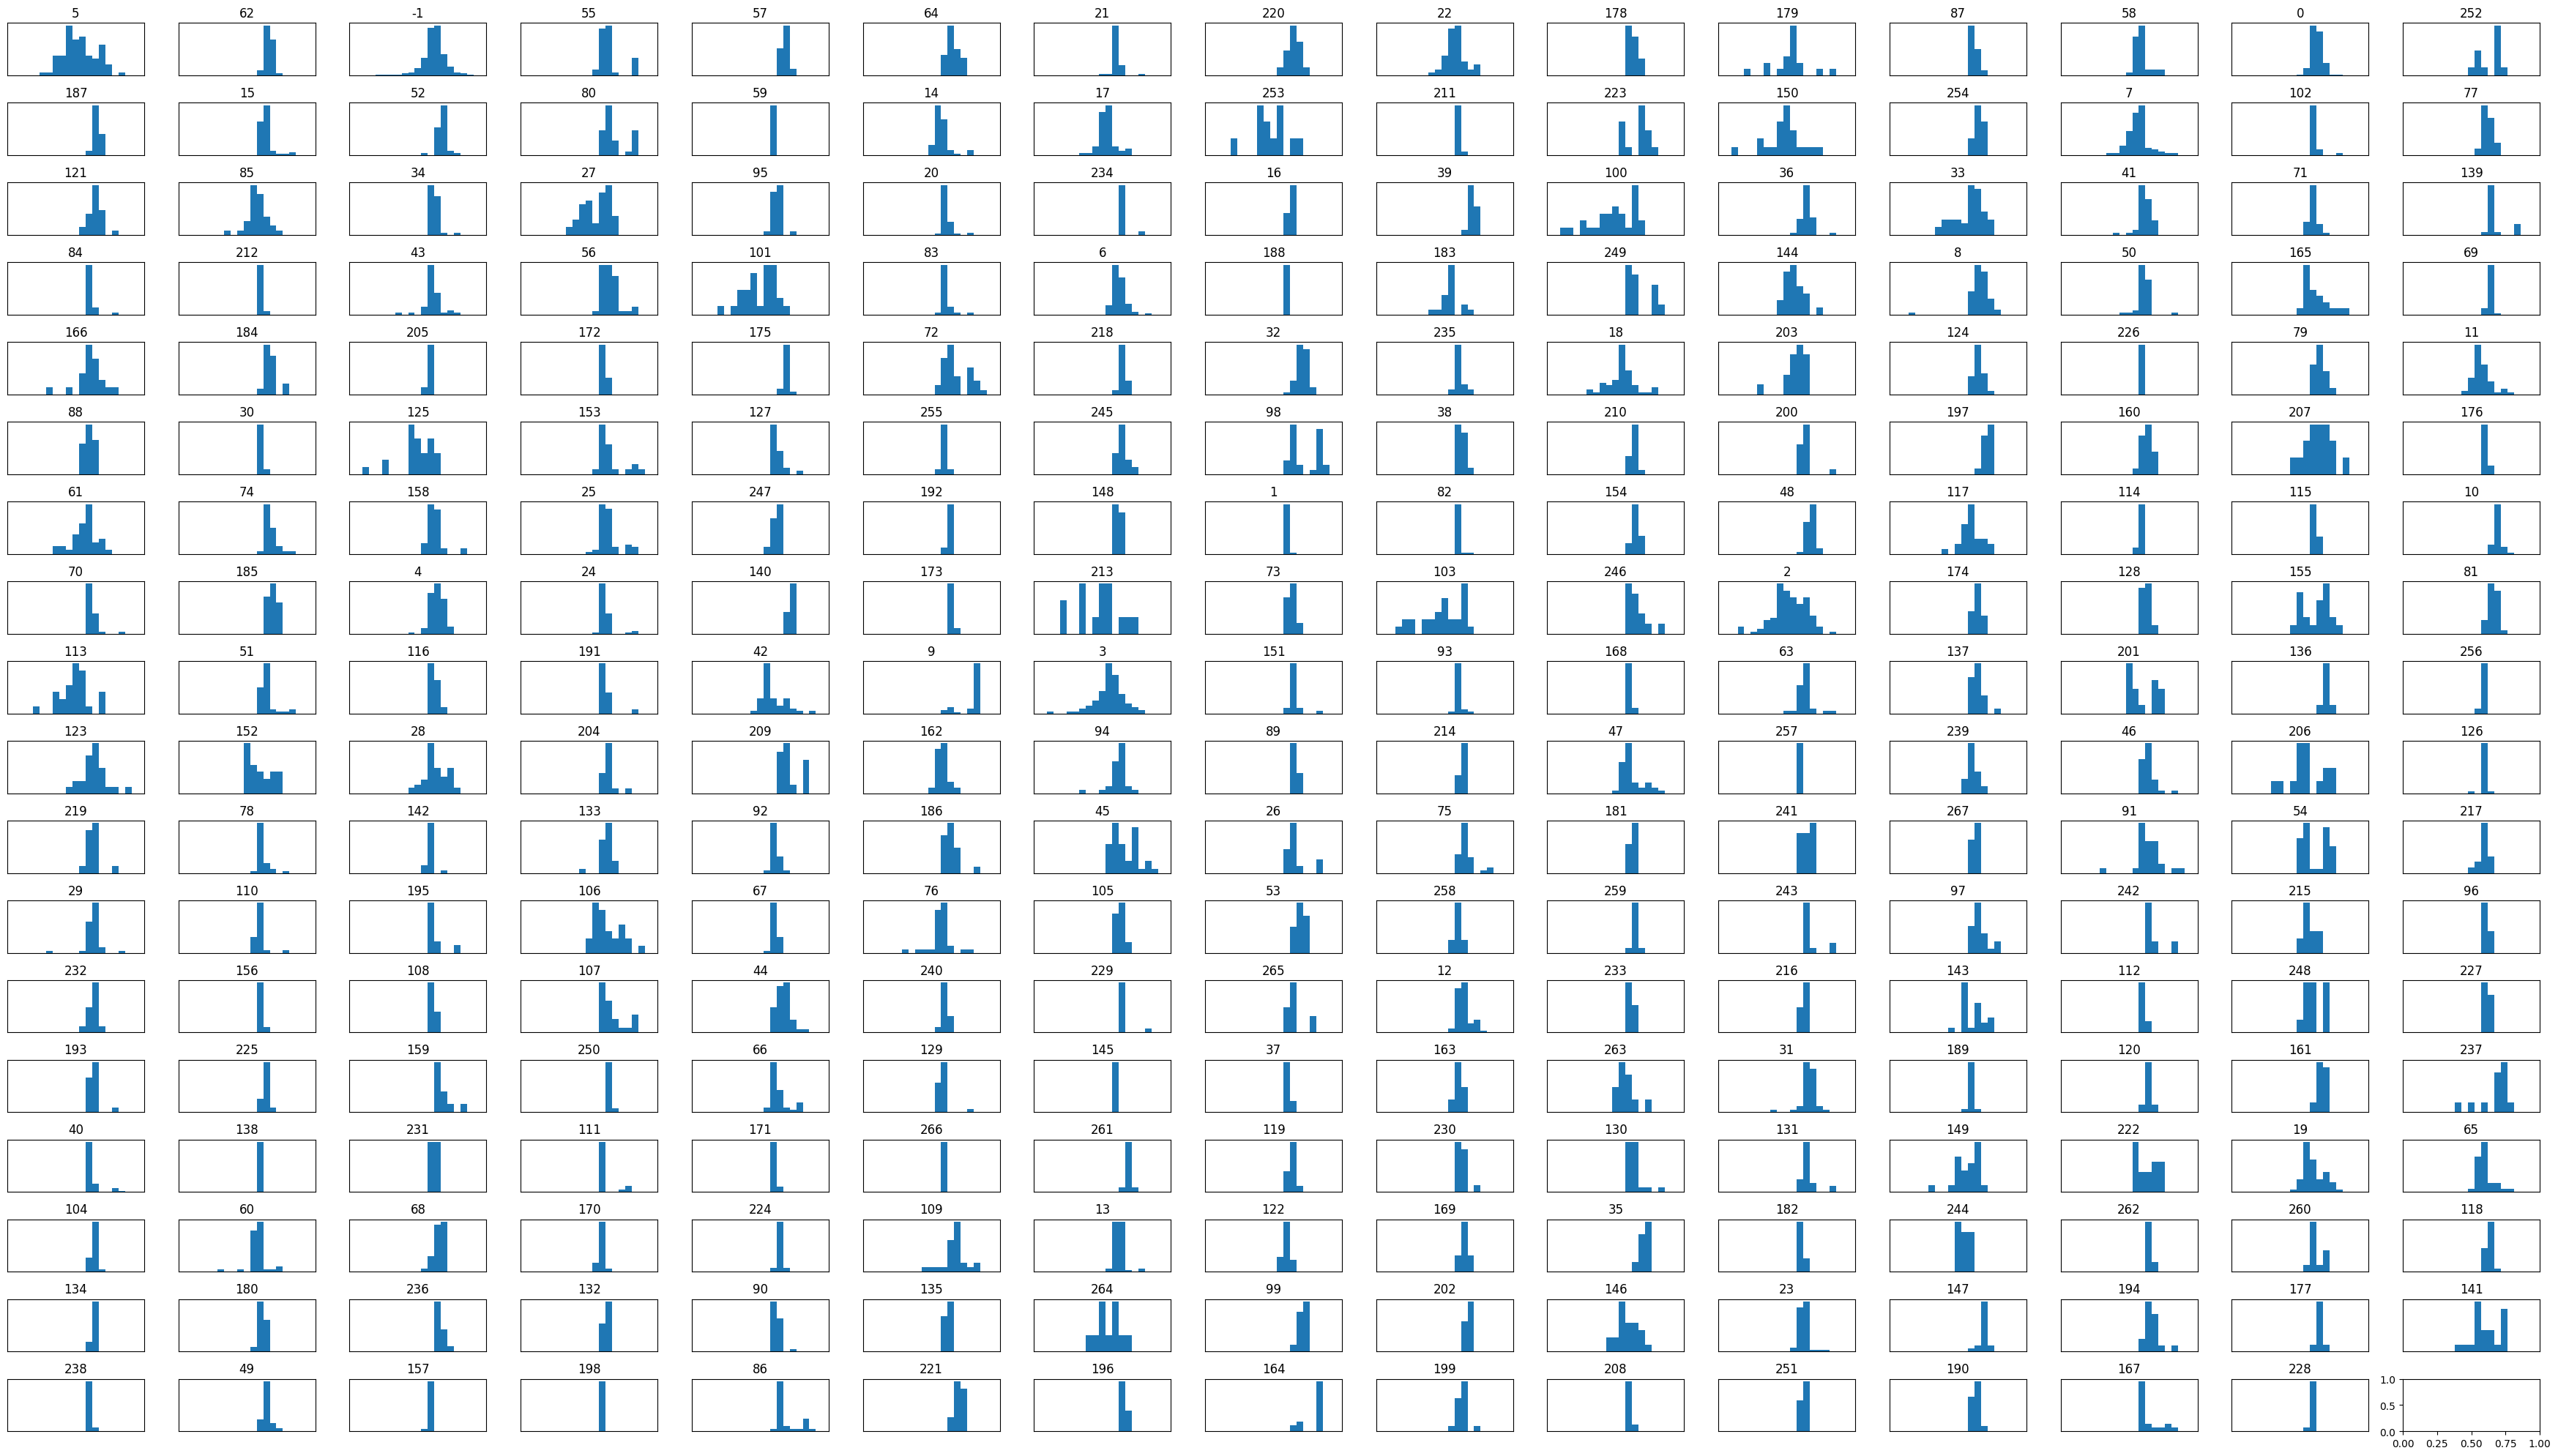

In [110]:
# Show the distribution of scores for all topics
n_topics = len(np.unique(topic_model.topics_))

N_COLS = 15
N_ROWS = int(np.ceil(n_topics / N_COLS))

fig, ax = plt.subplots(N_ROWS, N_COLS, figsize=(35, 20))

bins = np.linspace(0.11, 0.22, 20)

for i, (topic_id, quality_scores) in enumerate(topic_quality_scores.items()):
    ax[i // N_COLS, i % N_COLS].hist(quality_scores, bins=bins)
    ax[i // N_COLS, i % N_COLS].set_title(f"{topic_id}")
    ax[i // N_COLS, i % N_COLS].set_yticks([])
    ax[i // N_COLS, i % N_COLS].set_xticks([])

fig.tight_layout()

In [114]:
# Compute the mean and std score for each topic
topic_quality_scores_mean = {id: np.mean(scores) for id, scores in topic_quality_scores.items()}
topic_quality_scores_std = {id: np.std(scores) for id, scores in topic_quality_scores.items()}

# Sort the topics by their id
sorted_topic_quality_scores_mean = sorted(topic_quality_scores_mean.items(), key=lambda x: x[0])
sorted_topic_quality_scores_std = sorted(topic_quality_scores_std.items(), key=lambda x: x[0])

In [141]:
# Get the size of each topic
topic_sizes = Counter(topic_model.topics_)

In [142]:
topic_sizes = {id: size for id, size in sorted(topic_sizes.items(), key=lambda x: x[0])}

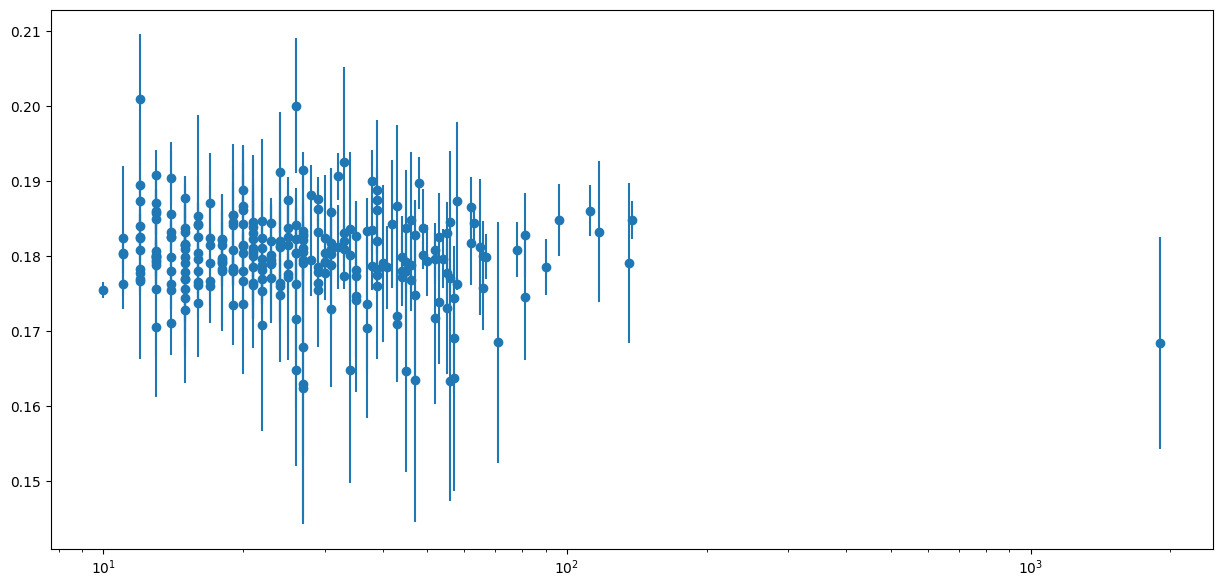

In [143]:
# Plot an errorbar plot for each topic
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.errorbar(list(topic_sizes.values()), list(topic_quality_scores_mean.values()), yerr=list(topic_quality_scores_std.values()), fmt='o')
ax.set_xscale('log')

In [148]:
import pandas as pd

In [150]:
# for id, _ in sorted(topic_quality_scores_mean.items(), key=lambda x: x[1], reverse=True):
#     print(f"Topic {id}: {topic_model.get_topic(id)}, size: {topic_sizes[id]}, mean: {topic_quality_scores_mean[id]:.5f}, std: {topic_quality_scores_std[id]:.5f}")

# Create a dataframe with the topic id, name, size, mean score, and std score
score_df = pd.DataFrame({
    "id": [id for id, _ in sorted_topic_quality_scores_mean],
    "name": [topic_model.get_topic(id) for id, _ in sorted_topic_quality_scores_mean],
    "size": [topic_sizes[id] for id, _ in sorted_topic_quality_scores_mean],
    "mean": [mean for _, mean in sorted_topic_quality_scores_mean],
    "std": [std for _, std in sorted_topic_quality_scores_std],
})

In [152]:
# Save the dataframe to a csv file
score_df.to_csv("topic_scores.csv", index=False)

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Read the dataframe from a csv file
score_df = pd.read_csv("topic_scores.csv")


In [4]:
score_df

id                                               name  size      mean  \
0     -1  [('dataset management and column filtering in ...  1905  0.179021   
1      0  [('Extracting and Combining Script and Episode...   138  0.179945   
2      1  [('Display first few rows of characters datafr...   136  0.177759   
3      2      [('Data merging and joining with pandas', 1)]   117  0.167871   
4      3        [('Filtering spoken lines in a script', 1)]   112  0.171588   
..   ...                                                ...   ...       ...   
264  263     [('Gender analysis and data manipulation', 1)]    11  0.173697   
265  264                           [('Character Lines', 1)]    11  0.170551   
266  265                      [('NLP Tools with Spacy', 1)]    11  0.184090   
267  266  [('Visualizing the first few rows of the chara...    11  0.175579   
268  267         [('Handling NaN Values in Dataframes', 1)]    10  0.180406   

          std  
0    0.010663  
1    0.004750  
2    0.001260  
3    0.014722  
4    0.011863  
..        ...  
264  0.007238  
265  0.009421  
266  0.006894  
267  0.001126  
268  0.001996  

[269 rows x 5 columns]